## Capstone Project 1: Ford Car Price Prediction

This Jupyter Notebook records the entire development flow of a Machine Learning project focused on predicting the price of Ford cars based on attributes such as mileage, year of manufacture, engine specifications (engineSize, mpg, etc.), and other relevant variables. The project aims to create a reliable and scalable solution, exploring everything from exploratory data analysis (EDA) to evaluation and comparison of multiple models.

## Project Overview

The objective is to predict the price of Ford cars based on their attributes. Accurate price predictions are crucial for car dealerships, online platforms, and individual sellers to make data-driven pricing decisions. This project provides a structured approach, from data exploration to model deployment, ensuring the solution is practical and usable.

#### Approach:

1. Data Collection and Preparation
- Reading the dataset ford_car_price_prediction.csv.
- Standardizing columns (removing spaces, converting to lowercase).
- Handling missing values.
- Removing outliers using the IQR method, when necessary.
- Creating derived attributes, if applicable (e.g.: categorizing year or conditioning engineSize).
- Splitting between training and validation data (train_test_split).

2. Exploratory Analysis (EDA)
- Generation of descriptive statistics (describe, info).
- Visualizations:
- Boxplots to detect outliers or understand price distribution by model.
- Histograms for each numeric variable.
- Correlation heatmaps to evaluate the relationships between features and price.
- Scatterplots to relate, for example, mileage vs price, coloring by transmission.
- Violinplots or stripplots to see distribution by model or fuelType.

3. Model Training and Evaluation
- Several regressive models were tested, for example:
- Linear Regression
- Ridge Regression
- Lasso Regression
- XGBoost Regressor
- Use of pipelines to unify preprocessing (OneHotEncoder) and the final estimator.
- Hyperparameter tuning (GridSearchCV) to maximize performance.

4. Evaluation metrics:
- RMSE (Root Mean Squared Error) – To measure the average absolute error in terms of price.
- R² (coefficient of determination) – To evaluate how much price variability is explained by the model.
- Comparison of results and selection of the final model.

5. Export and Reproducibility
- Saving the pipeline (with all encoders and scaler) via joblib.dump().
- Creation of a train.py script to allow automated re-training.
- Possibility of testing on new samples (test.py) to check consistency.

6. Deployment
- Create an API or Docker container for deployment in a production environment.

### Data preparation

In [60]:
# =============================================================================
# Python Standard Libraries
# =============================================================================
import warnings
import json
import pickle
import joblib
from math import sqrt

# =============================================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# =============================================================================
# Scikit-Learn Libraries
# =============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import (
    LogisticRegression, LinearRegression, Ridge, Lasso
)
from sklearn.metrics import (
    mutual_info_score, accuracy_score, roc_curve, roc_auc_score,
    classification_report, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score
)
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder
)
from sklearn.tree import DecisionTreeClassifier, export_text

# =============================================================================
# # Other libraries
# =============================================================================
from tqdm.auto import tqdm
from xgboost import XGBRegressor

In [61]:
warnings.filterwarnings("ignore", category=FutureWarning)

### 1. Data Loading

In [62]:
data = pd.read_csv("ford_car_price_prediction.csv")
data.columns = data.columns.str.lower().str.replace(' ', '_')

## Basic overview

In [63]:
data_path = "ford_car_price_prediction.csv"
print("First 10 lines of the dataset:")
!head $data_path

First 10 lines of the dataset:
model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
 Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1
 Focus,2018,14000,Manual,9083,Petrol,150,57.7,1
 Focus,2017,13000,Manual,12456,Petrol,150,57.7,1
 Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
 Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1
 Fiesta,2015,10500,Manual,35432,Petrol,145,47.9,1.6
 Puma,2019,22500,Manual,2029,Petrol,145,50.4,1
 Fiesta,2017,9000,Manual,13054,Petrol,145,54.3,1.2
 Kuga,2019,25500,Automatic,6894,Diesel,145,42.2,2


In [64]:
df = pd.read_csv(data_path)
df.head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
5,Fiesta,2015,10500,Manual,35432,Petrol,145,47.9,1.6
6,Puma,2019,22500,Manual,2029,Petrol,145,50.4,1.0
7,Fiesta,2017,9000,Manual,13054,Petrol,145,54.3,1.2
8,Kuga,2019,25500,Automatic,6894,Diesel,145,42.2,2.0
9,Focus,2018,10000,Manual,48141,Petrol,145,61.4,1.0


### 2. Exploratory Data Analysis (EDA)

In [65]:
print("\nColumns:", df.columns)
print(df.info())


Columns: Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1460 non-null   object 
 1   year          1460 non-null   int64  
 2   price         1460 non-null   int64  
 3   transmission  1460 non-null   object 
 4   mileage       1460 non-null   int64  
 5   fuelType      1460 non-null   object 
 6   tax           1460 non-null   int64  
 7   mpg           1460 non-null   float64
 8   engineSize    1460 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 102.8+ KB
None


In [66]:
print(df.describe())

              year         price       mileage          tax          mpg  \
count  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean   2016.993836  12280.198630  21907.027397   108.205479    58.609726   
std       1.632212   4447.710936  15874.464065    62.334075     9.577440   
min    2013.000000   3691.000000      5.000000     0.000000    20.900000   
25%    2016.000000   9000.000000  10174.000000    30.000000    54.300000   
50%    2017.000000  11199.000000  17863.500000   145.000000    58.900000   
75%    2018.000000  14998.000000  29859.750000   145.000000    65.700000   
max    2020.000000  42489.000000  88927.000000   570.000000    88.300000   

        engineSize  
count  1460.000000  
mean      1.361438  
std       0.436243  
min       1.000000  
25%       1.000000  
50%       1.200000  
75%       1.500000  
max       5.000000  


In [67]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64


In [68]:
target_label = "price"

In [69]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
if target_label in numeric_columns:
    numeric_columns.remove(target_label)

object_columns = df.select_dtypes(include=["object"]).columns.tolist()

X = df[numeric_columns]
y = df[target_label]
print("\nFeatures (X):", X.columns)
print("Target (y):", target_label)


Features (X): Index(['year', 'mileage', 'tax', 'mpg', 'engineSize'], dtype='object')
Target (y): price


### Plot Distributions for Numerical Columns


Boxplot of numeric columns:


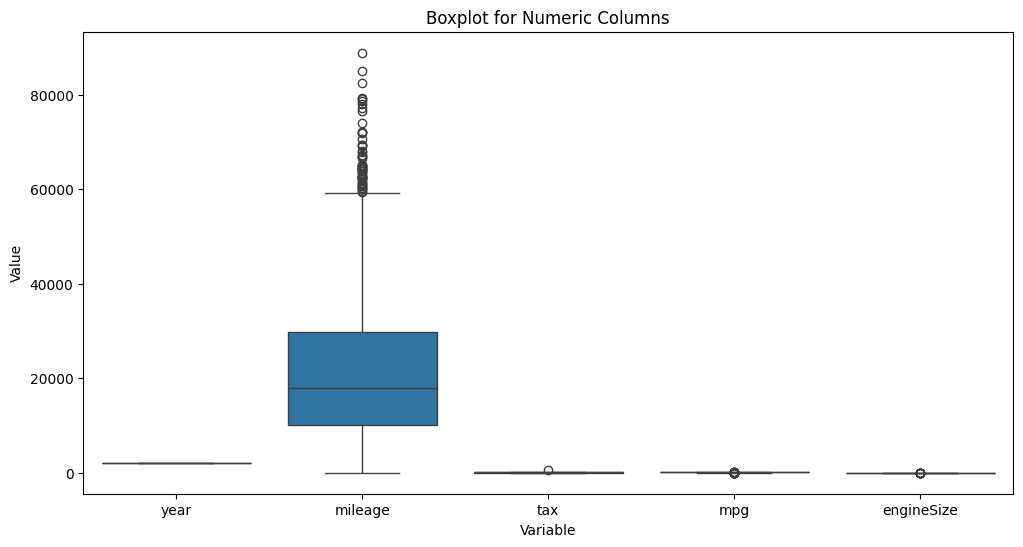

In [70]:
def showBoxplt(df_):
    df_melted = df_.melt(var_name="Variable", value_name="Value")
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Variable", y="Value", data=df_melted)
    plt.title("Boxplot for Numeric Columns")
    plt.show()

print("\nBoxplot of numeric columns:")
showBoxplt(df[numeric_columns])

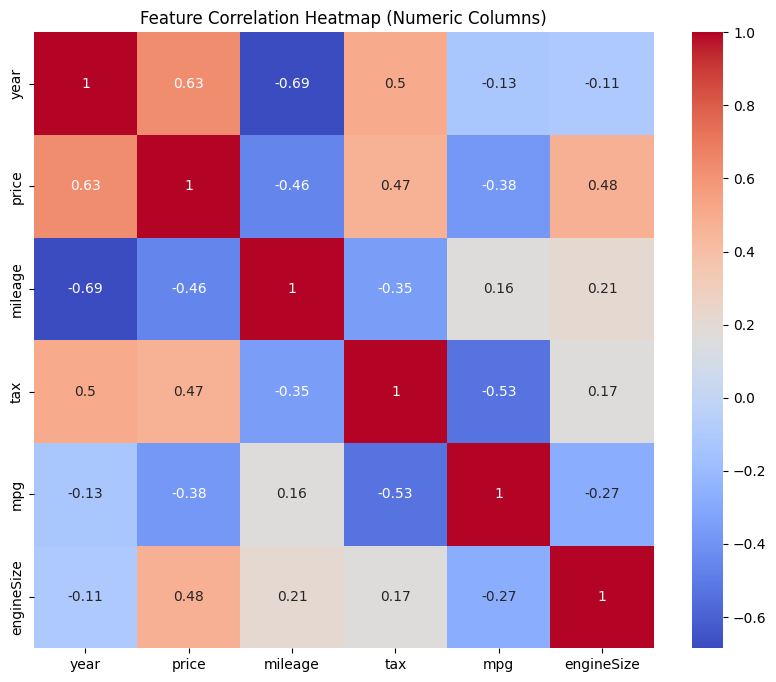

In [71]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap (Numeric Columns)")
plt.show()

In [72]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

if target_label in numeric_cols:
    correlation_target = df[numeric_cols].corr()[target_label].sort_values(ascending=False)
    print("\nCorrelation with target:", target_label)
    print(correlation_target)
else:
    print(f"'{target_label}' is not in numeric columns. Please ensure the target is numeric.")


Correlation with target: price
price         1.000000
year          0.628646
engineSize    0.478156
tax           0.470569
mpg          -0.378478
mileage      -0.456676
Name: price, dtype: float64


### (A) Histogram of Price

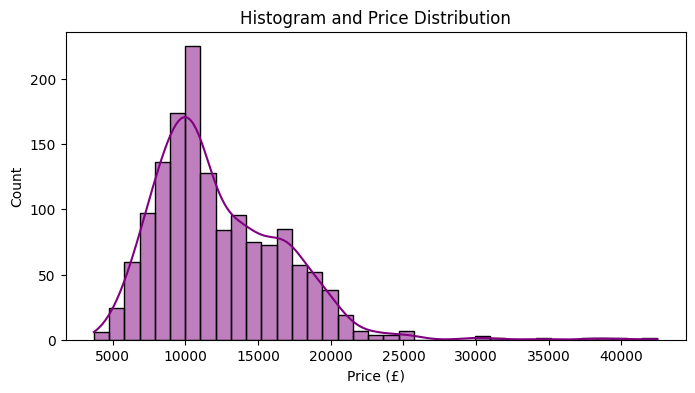

In [74]:
plt.figure(figsize=(8,4))
sns.histplot(data[target_label], kde=True, color='purple')
plt.title("Histogram and Price Distribution")
plt.xlabel("Price (£)")
plt.ylabel("Count")
plt.show()

### (B) Histograms/KDE of Numerical Columns

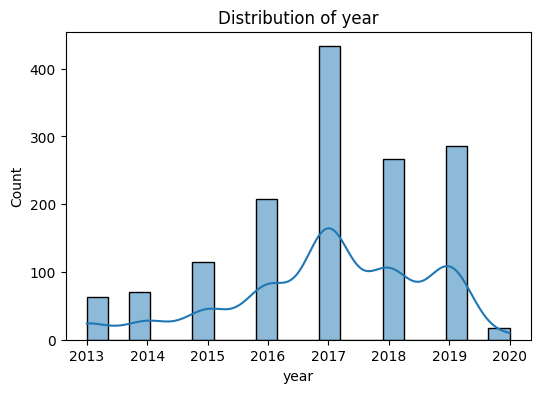

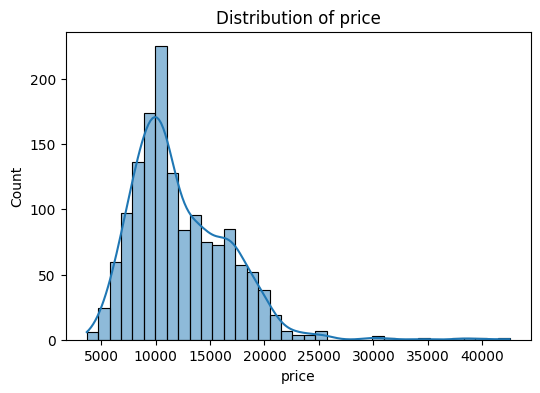

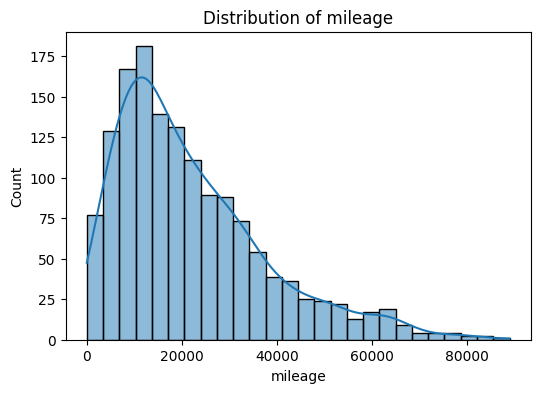

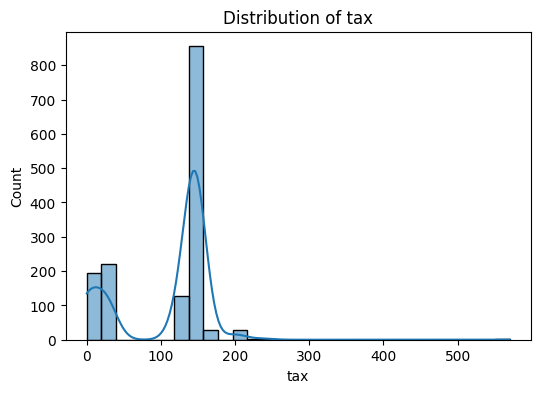

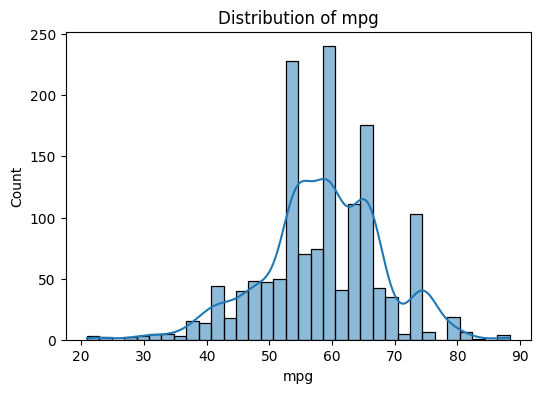

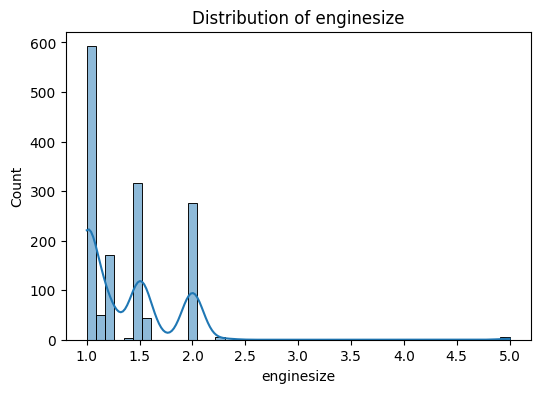

In [75]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

### (C) Countplot of a Categorical Feature (Example: Brand)

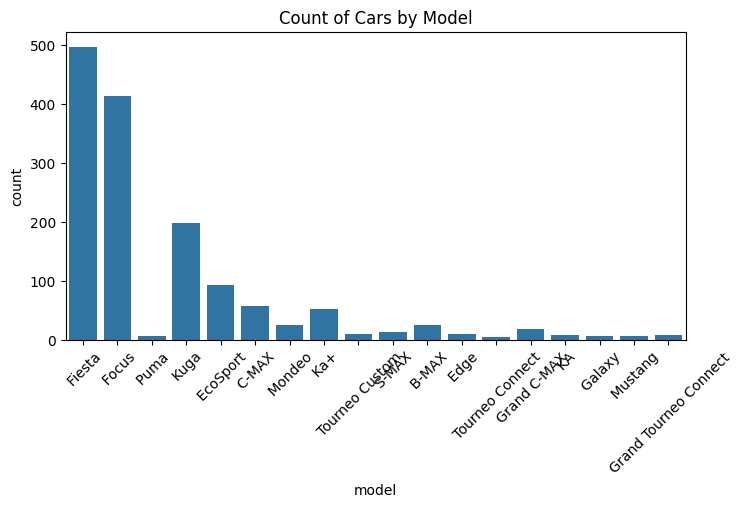

In [76]:
plt.figure(figsize=(8,4))
sns.countplot(x='model', data=data)
plt.title("Count of Cars by Model")
plt.xticks(rotation=45)
plt.show()

### (D) Violinplot: Brand vs. Price

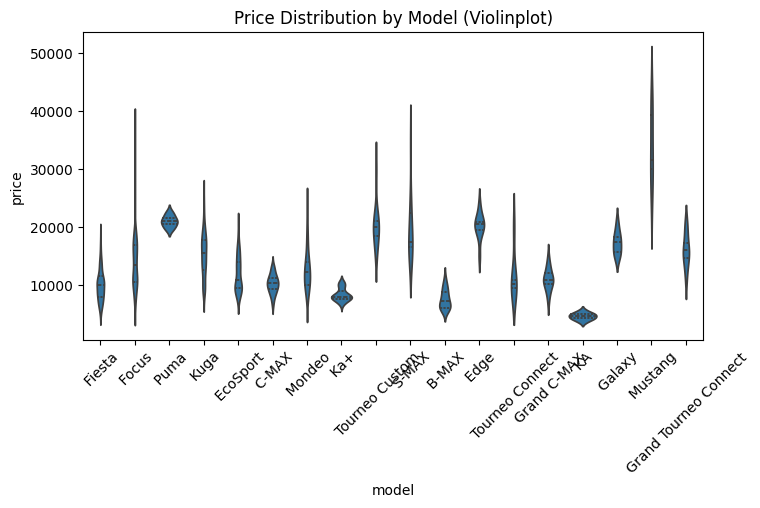

In [18]:
if 'model' in data.columns:
    plt.figure(figsize=(8, 4))
    sns.violinplot(
        x='model', 
        y=target_label, 
        data=data, 
        inner='quartile'
    )
    plt.title("Price Distribution by Model (Violinplot)")
    plt.xticks(rotation=45)
    plt.show()

### (E) Stripplot with Hue

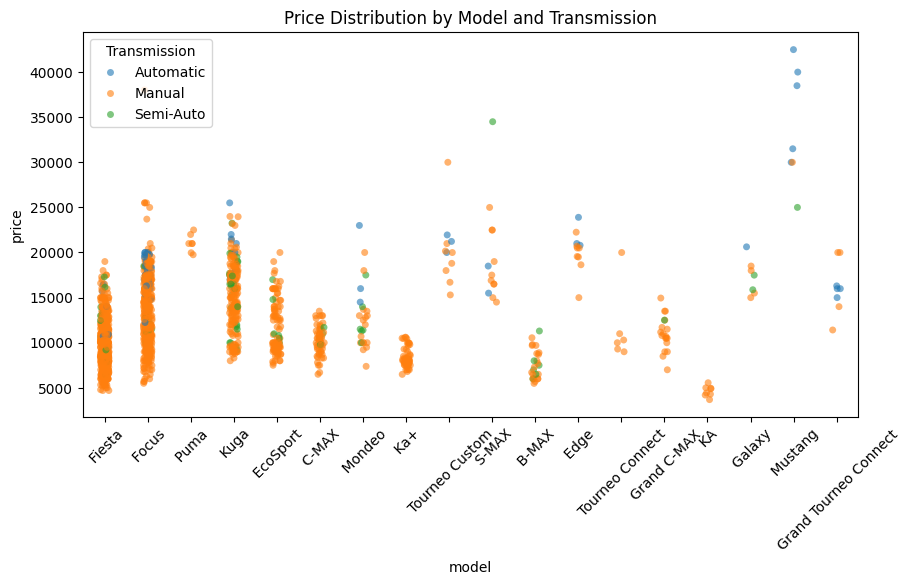

In [19]:
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

if 'model' in categorical_cols and 'transmission' in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.stripplot(x='model', y='price', hue='transmission', data=data, jitter=True, alpha=0.6)
    plt.title("Price Distribution by Model and Transmission")
    plt.xticks(rotation=45)
    plt.legend(title='Transmission')
    plt.show()

### (F) Boxplot of mpg vs Brand (if both exist)

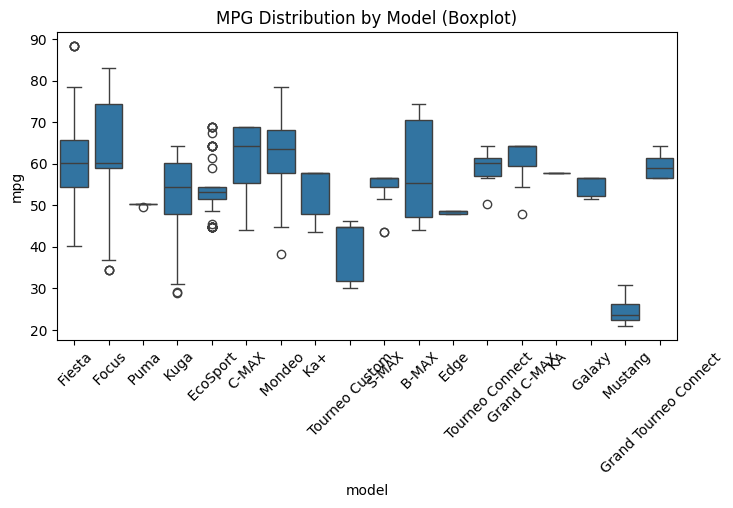

In [20]:
if 'model' in categorical_cols and 'mpg' in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='model', y='mpg', data=data)
    plt.title("MPG Distribution by Model (Boxplot)")
    plt.xticks(rotation=45)
    plt.show()

### (G) Scatterplot mpg vs price, hue=transmission

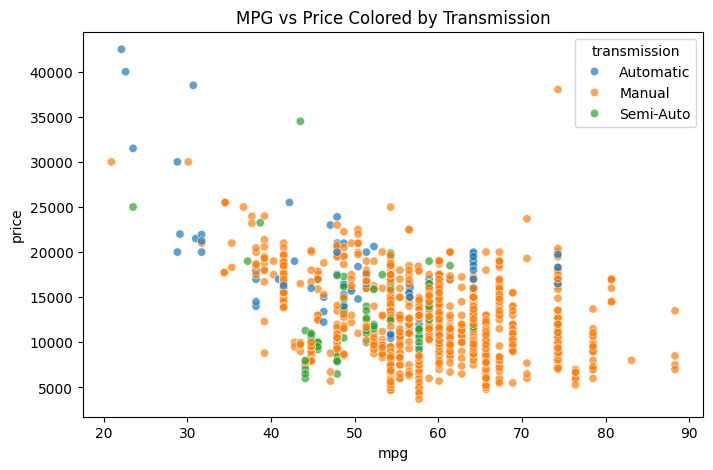

In [21]:
if 'mpg' in numerical_cols and 'transmission' in categorical_cols:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='mpg', y='price', hue='transmission', data=data, alpha=0.7)
    plt.title("MPG vs Price Colored by Transmission")
    plt.show()

### (H) Jointplot of Mileage vs. Price

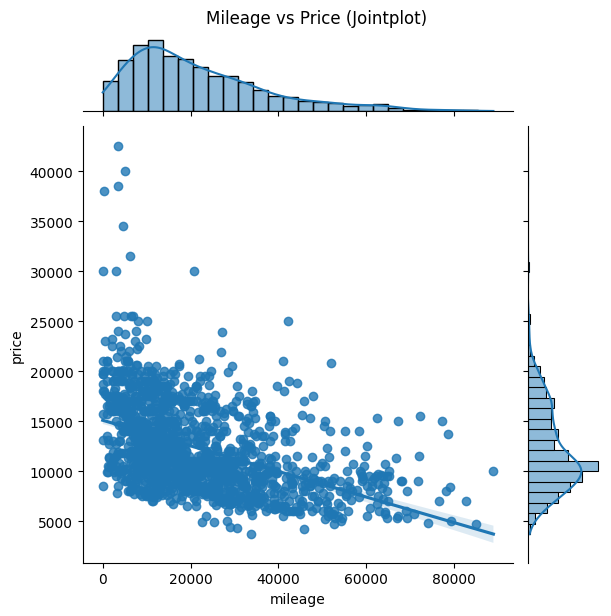

In [22]:
if 'mileage' in numerical_cols:
    sns.jointplot(x='mileage', y='price', data=data, kind='reg', height=6)
    plt.suptitle("Mileage vs Price (Jointplot)", y=1.02)
    plt.show()

### (I) Regplot of Engine Size vs Price

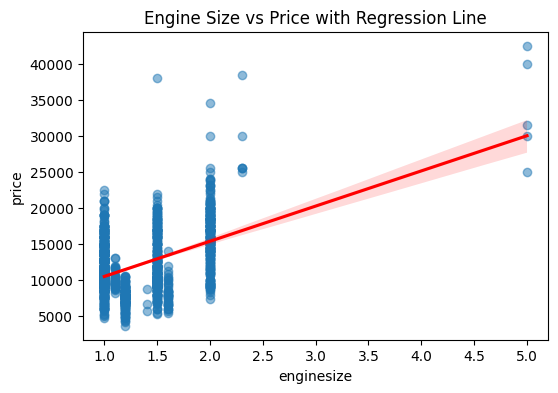

In [23]:
if 'enginesize' in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.regplot(x='enginesize', y='price', data=data, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
    plt.title("Engine Size vs Price with Regression Line")
    plt.show()

### (J) Correlation Heatmap (Numerical + Price)

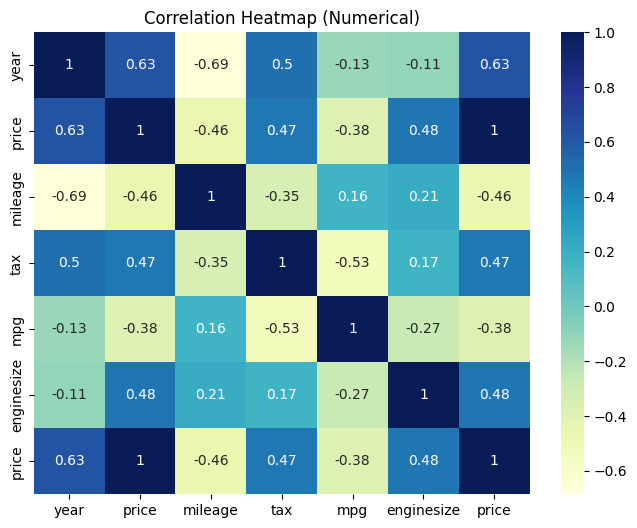

In [24]:
corr = data[numerical_cols + [target_label]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap (Numerical)")
plt.show()

### (K) Line plot - Distribution of average price by year (year)

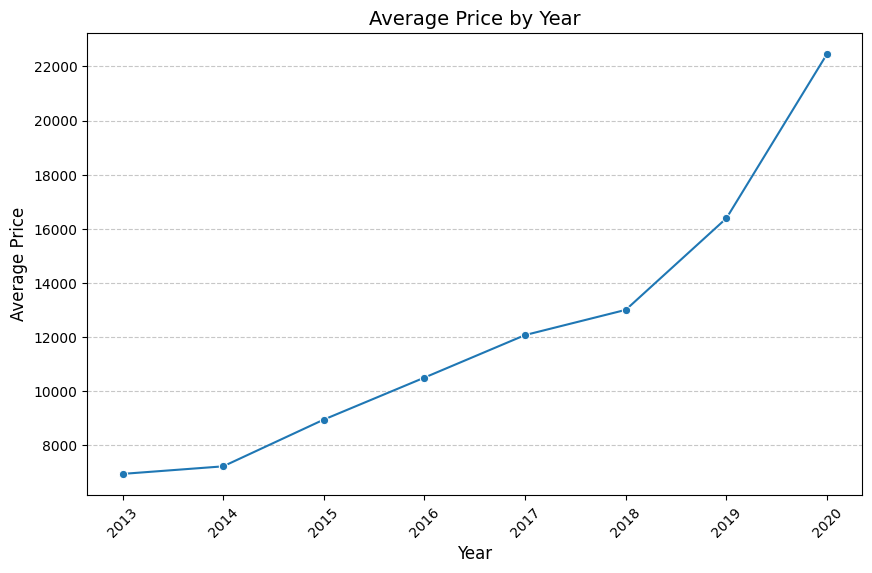

In [25]:
if 'year' in data.columns and 'price' in data.columns:
    plt.figure(figsize=(10, 6))

    year_price_mean = data.groupby('year')['price'].mean().sort_index()

    sns.lineplot(x=year_price_mean.index, y=year_price_mean.values, marker='o')
    plt.title("Average Price by Year", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Average Price", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.show()

### (L) Scatter Plot - Price vs Mileage

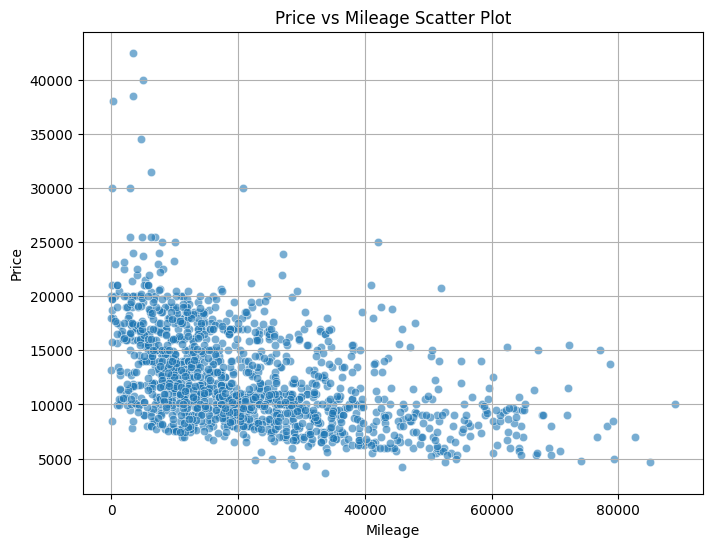

In [26]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='mileage', y='price', data=data, alpha=0.6)
plt.title("Price vs Mileage Scatter Plot")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.grid(True)
plt.show()

### Remove Outliers

In [27]:
def remove_outliers_iqr(df, column):

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

numerical_cols_to_process = ['price', 'mileage', 'tax', 'mpg', 'engineSize']

for col in numerical_cols_to_process:
    if col in df.columns:
        df = remove_outliers_iqr(df, col)

print("Outliers removed for the specified numerical columns.")

Outliers removed for the specified numerical columns.


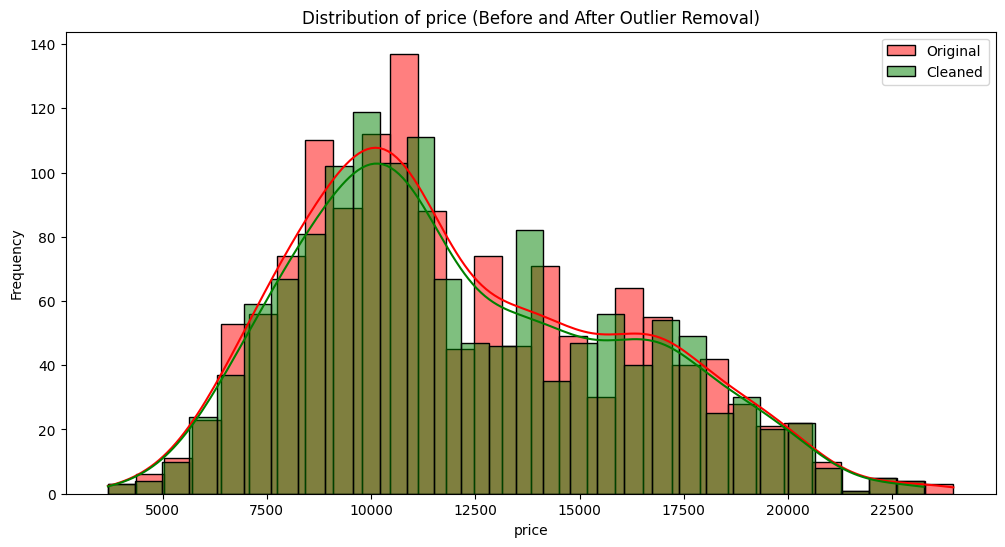

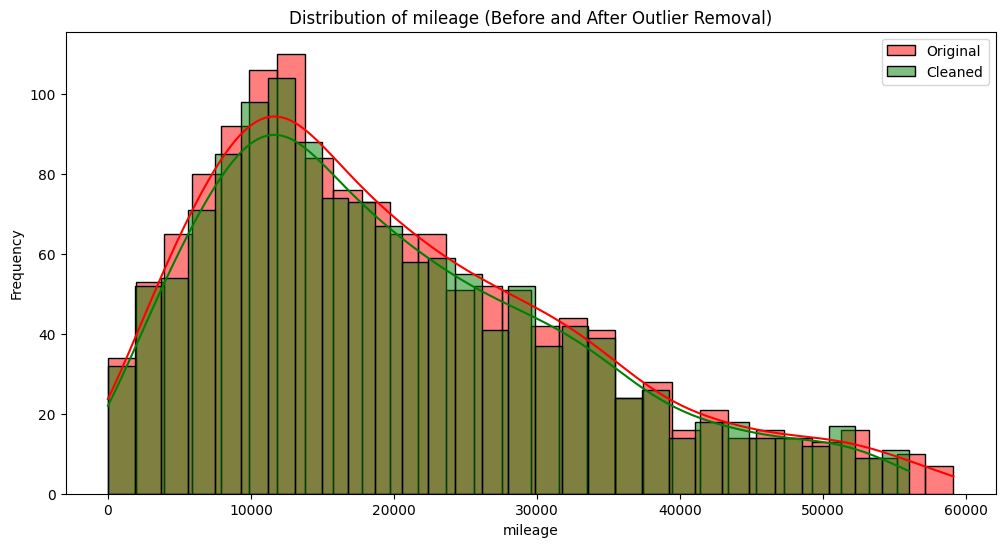

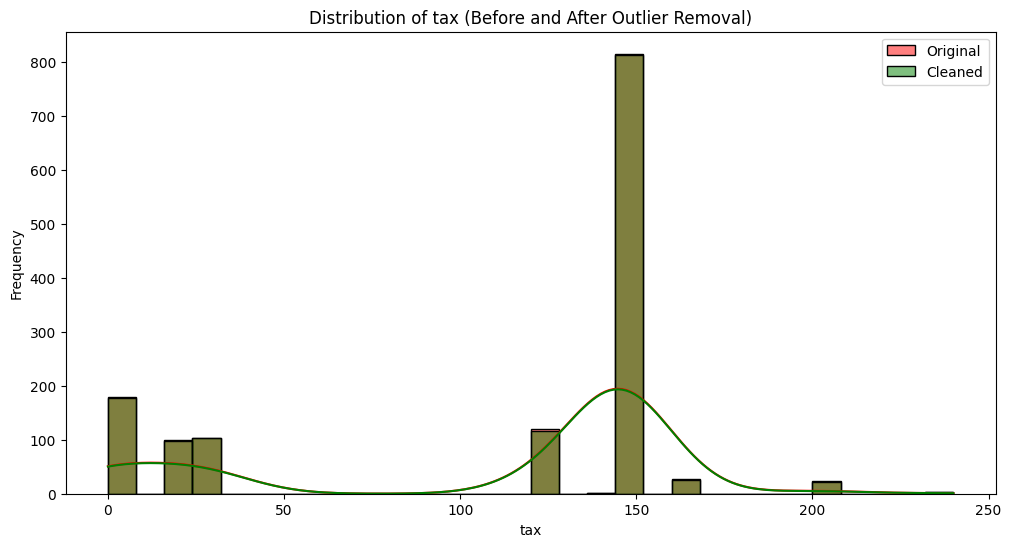

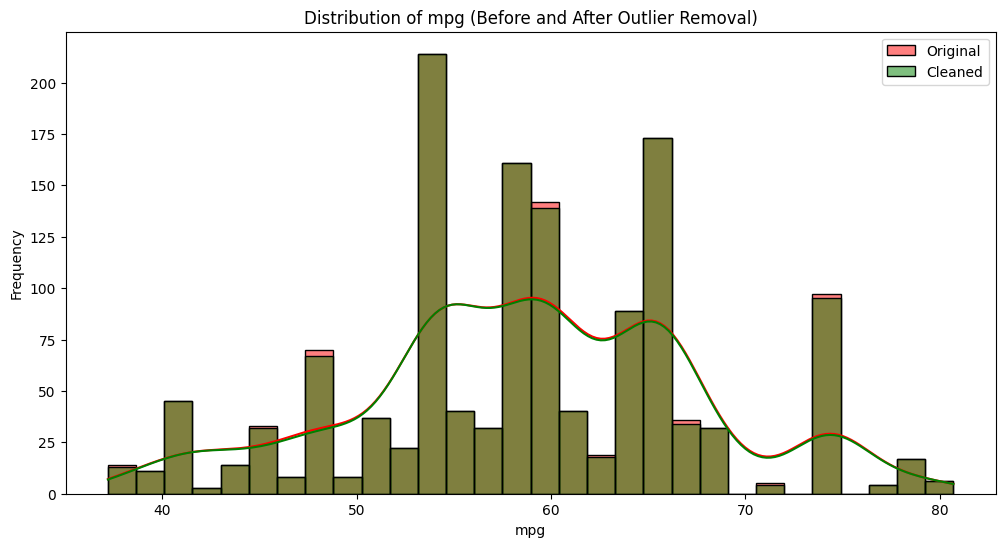

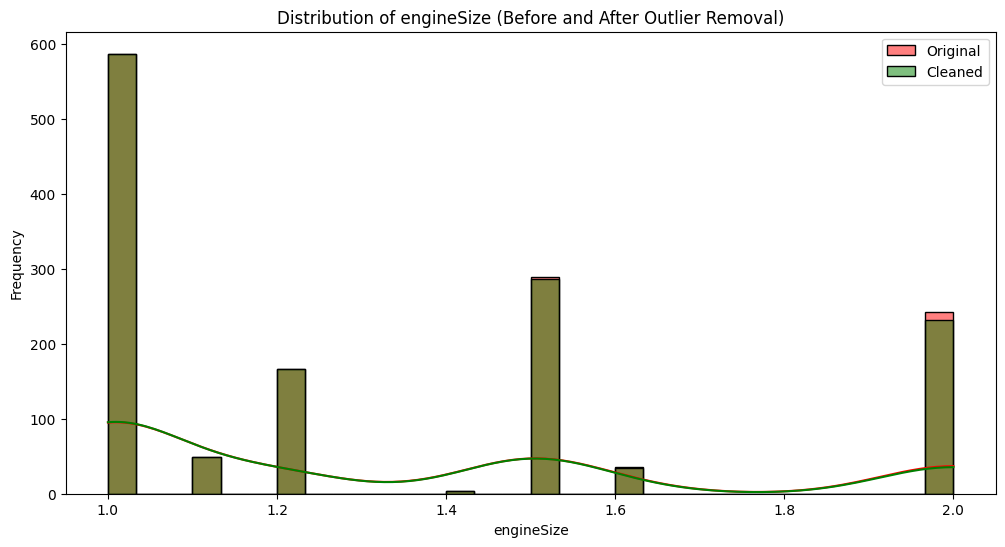

In [28]:
def plot_outliers_removal(df_original, df_cleaned, column):

    plt.figure(figsize=(12, 6))
    
    sns.histplot(df_original[column], kde=True, color="red", label="Original", bins=30, alpha=0.5)
    
    sns.histplot(df_cleaned[column], kde=True, color="green", label="Cleaned", bins=30, alpha=0.5)
    
    plt.title(f"Distribution of {column} (Before and After Outlier Removal)")
    plt.legend()
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

df_original = df.copy()

for col in numerical_cols_to_process:
    if col in df.columns:
        df = remove_outliers_iqr(df, col)

for col in numerical_cols_to_process:
    if col in df.columns:
        plot_outliers_removal(df_original, df, col)


Boxplot of numeric columns:


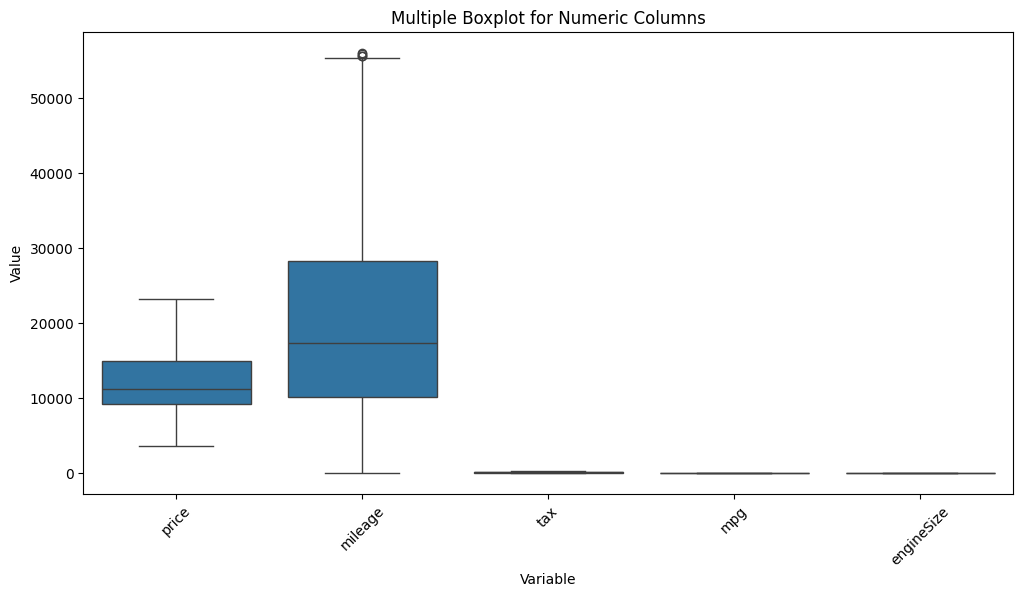

In [29]:
def show_multiple_boxplot(df_, numeric_columns):
    df_melted = df_[numeric_columns].melt(var_name="Variable", value_name="Value")
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Variable", y="Value", data=df_melted)
    plt.title("Multiple Boxplot for Numeric Columns")
    plt.xticks(rotation=45)
    plt.show()

print("\nBoxplot of numeric columns:")
show_multiple_boxplot(df, numerical_cols_to_process)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1358 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1358 non-null   object 
 1   year          1358 non-null   int64  
 2   price         1358 non-null   int64  
 3   transmission  1358 non-null   object 
 4   mileage       1358 non-null   int64  
 5   fuelType      1358 non-null   object 
 6   tax           1358 non-null   int64  
 7   mpg           1358 non-null   float64
 8   engineSize    1358 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 106.1+ KB


In [31]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000
mean,2017.067010,12145.345361,20001.967599,108.538292,58.927982,1.320471
std,1.568129,3861.017672,12808.609062,60.394024,8.689507,0.368361
min,2013.000000,3691.000000,5.000000,0.000000,37.200000,1.000000
25%,2016.000000,9232.500000,10149.250000,30.000000,54.300000,1.000000
50%,2017.000000,11298.000000,17360.500000,145.000000,58.900000,1.200000
75%,2018.000000,14998.000000,28312.000000,145.000000,65.700000,1.500000
max,2020.000000,23250.000000,56000.000000,240.000000,80.700000,2.000000


In [32]:
class_counts = df[target_label].value_counts()
class_ratio = class_counts.min() / class_counts.max()

print("Class counts for each category:")
print(class_counts)
print("\nClass imbalance ratio (minority/majority): {:.2f}".format(class_ratio))

if class_ratio < 0.5:
    print("Warning: Significant class imbalance detected.")
else:
    print("Class balance appears to be acceptable.")

Class counts for each category:
price
9998     40
10998    26
16998    26
8998     25
10498    25
         ..
9240      1
9900      1
16000     1
18798     1
17700     1
Name: count, Length: 559, dtype: int64

Class imbalance ratio (minority/majority): 0.03


### Correlation Heatmap

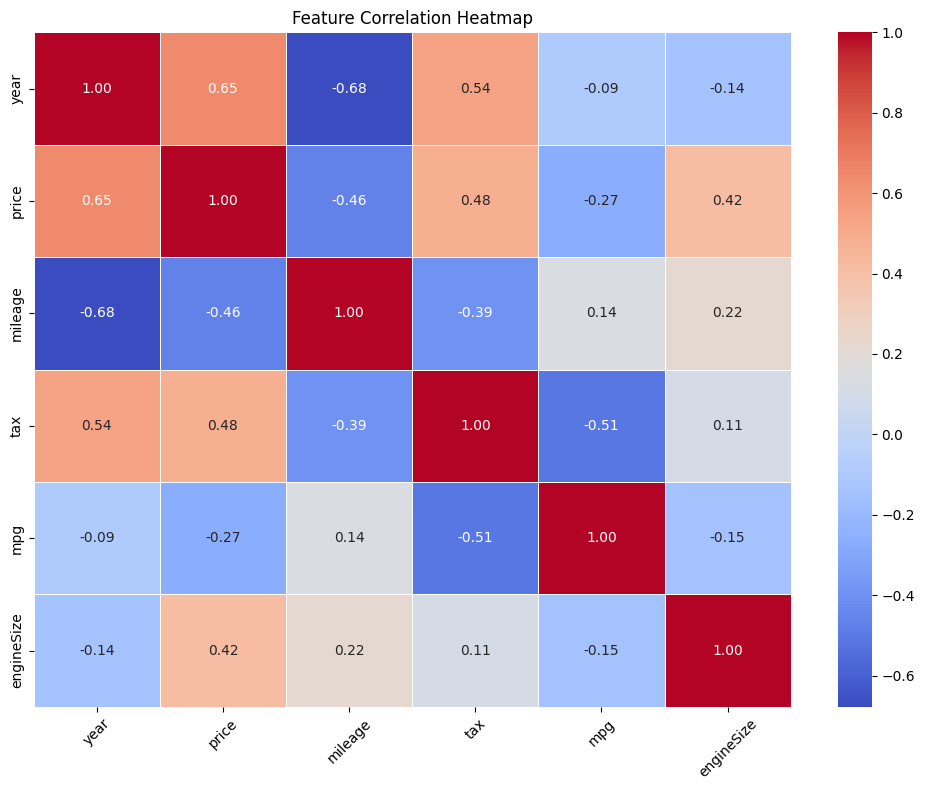

In [33]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

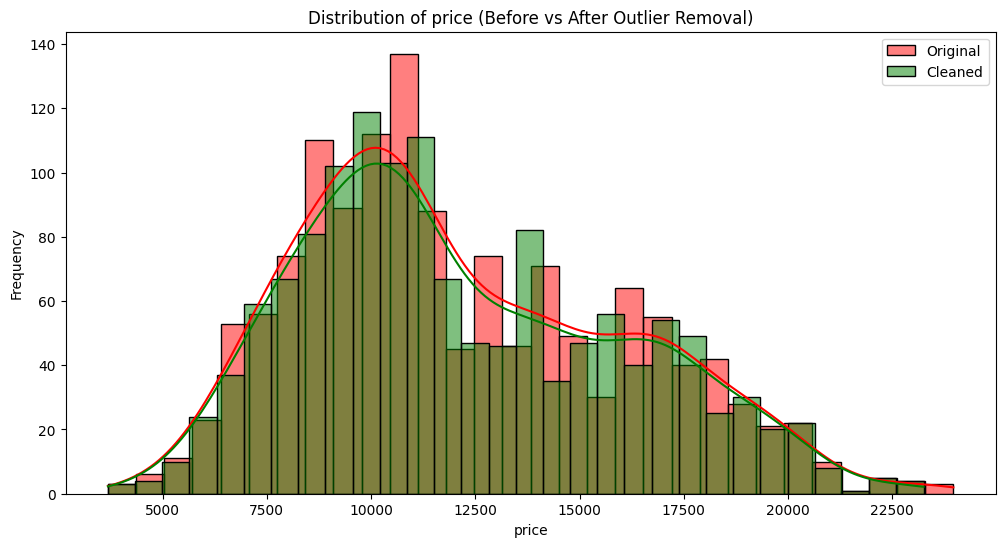

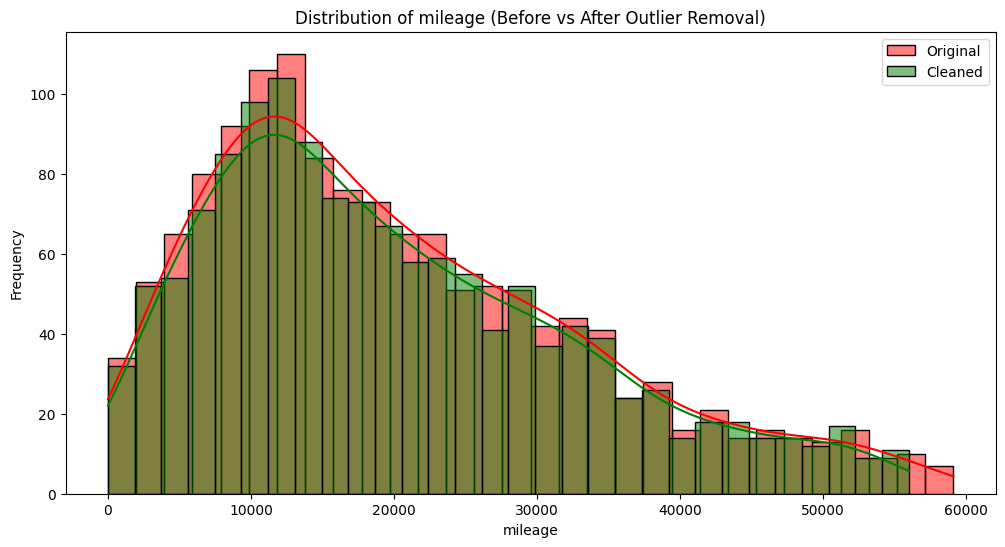

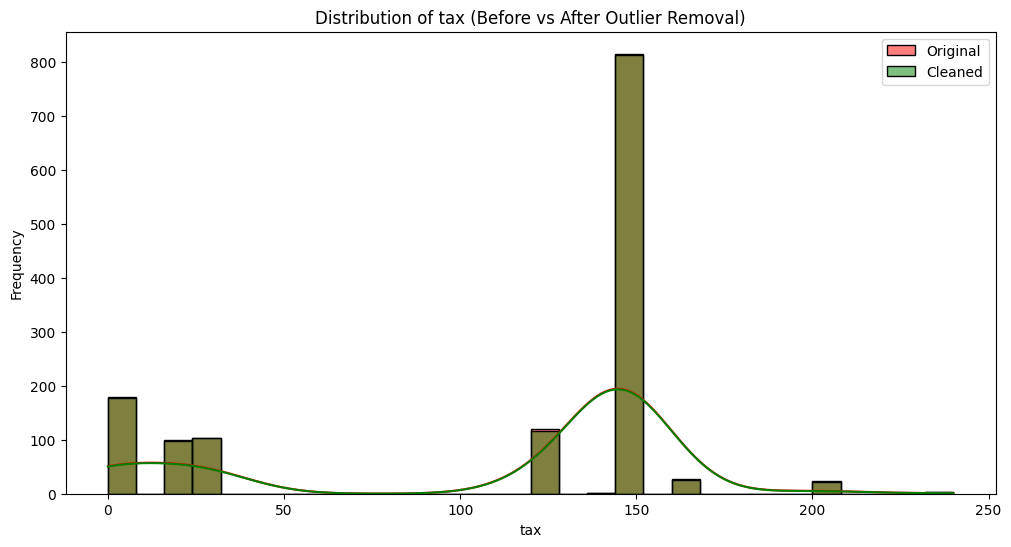

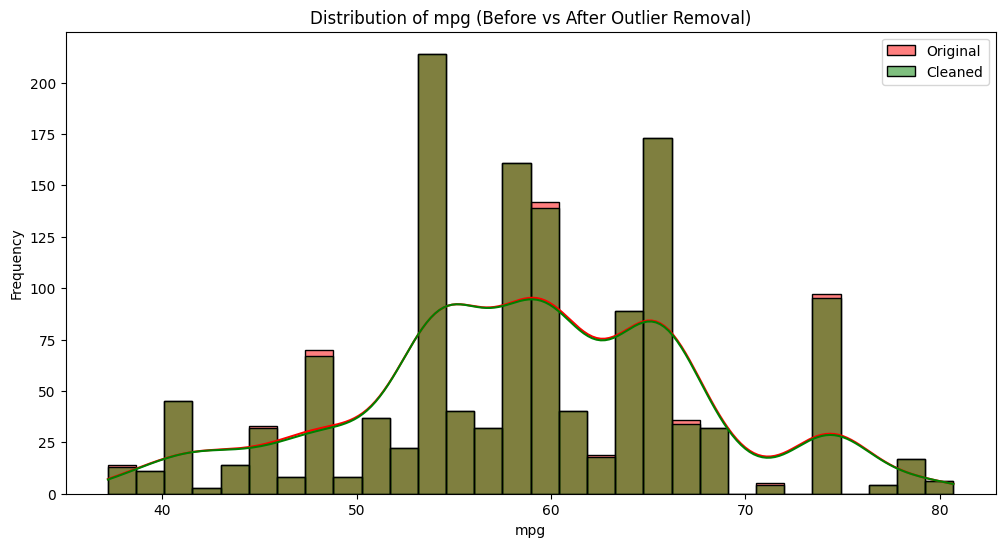

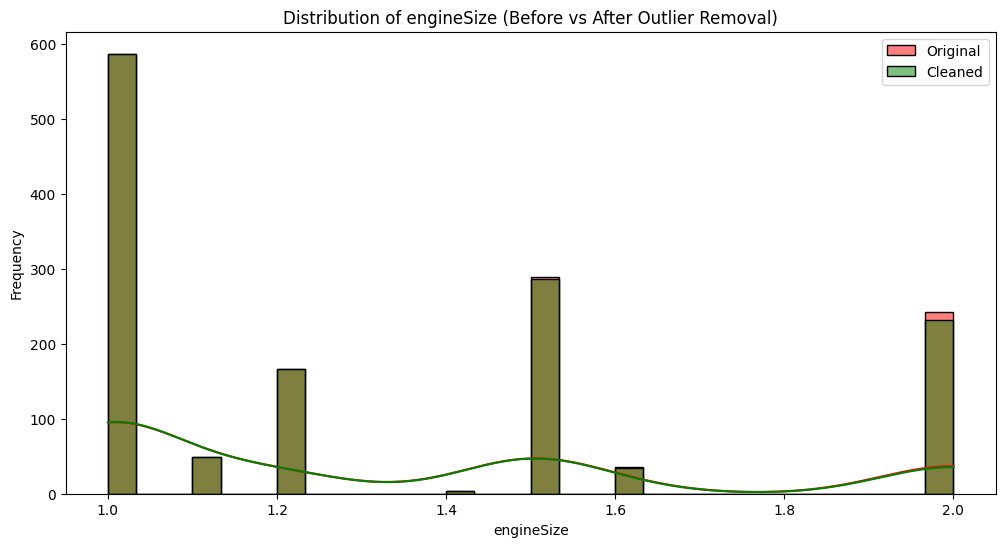

In [34]:
def plot_outliers_removal(df_original, df_cleaned, column):
    plt.figure(figsize=(12, 6))
    sns.histplot(df_original[column], kde=True, color="red", label="Original", bins=30, alpha=0.5)
    sns.histplot(df_cleaned[column], kde=True, color="green", label="Cleaned", bins=30, alpha=0.5)
    plt.title(f"Distribution of {column} (Before vs After Outlier Removal)")
    plt.legend()
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

for col in numerical_cols_to_process:
    if col in df.columns:
        plot_outliers_removal(df_original, df, col)

### 3.Data Preparation

In [48]:
target_label = 'price'

if target_label not in df.columns:
    raise ValueError(f"'{target_label}' not found in df. Check your data.")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_label in numeric_cols:
    numeric_cols.remove(target_label)

cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['year', 'mileage', 'tax', 'mpg', 'engineSize']
Categorical columns: ['model', 'transmission', 'fuelType']


In [49]:
def generate_data(df, target=target_label):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    df_train = df_full_train.reset_index(drop=True)
    df_val = df_test.reset_index(drop=True)

    y_train = df_train[target].values
    y_val = df_val[target].values

    del df_train[target]
    del df_val[target]

    return df_train, df_val, y_train, y_val

df_train, df_val, y_train, y_val = generate_data(df)
print("Train size:", len(df_train), "Val size:", len(df_val))

Train size: 1086 Val size: 272


In [50]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
    ]
)



In [51]:
pipelines = {
    'Linear Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]),
    'Ridge Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Ridge())
    ]),
    'Lasso Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Lasso())
    ]),
    'XGBoost': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
    ])
}

In [52]:
param_grids = {
    'Linear Regression': {
    },
    'Ridge Regression': {
        'model__alpha': np.logspace(-3, 3, 7)
    },
    'Lasso Regression': {
        'model__alpha': np.logspace(-3, 3, 7)
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

In [53]:
best_params = {}
for name, pipeline in pipelines.items():
    print("\n=== Model:", name, "===")
    if name in param_grids and param_grids[name]:
        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids[name],
            scoring='neg_mean_squared_error',
            cv=5,
            n_jobs=-1
        )
        grid.fit(df_train, y_train)
        best_params[name] = grid.best_params_
        print(f"Best Params: {grid.best_params_}")
    else:
        pipeline.fit(df_train, y_train)
        best_params[name] = "No hyperparameters tuned"


=== Model: Linear Regression ===

=== Model: Ridge Regression ===


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/prep

Best Params: {'model__alpha': np.float64(0.01)}

=== Model: Lasso Regression ===


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/prep

Best Params: {'model__alpha': np.float64(0.001)}

=== Model: XGBoost ===


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/prep

Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}


In [54]:
results = []
for name, pipeline in pipelines.items():
    if best_params[name] != "No hyperparameters tuned":
        pipeline.set_params(**best_params[name])
        pipeline.fit(df_train, y_train)

    predictions = pipeline.predict(df_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    r2 = r2_score(y_val, predictions)

    results.append({
        'Model': name,
        'RMSE': rmse,
        'R²': r2
    })

results_df = pd.DataFrame(results)
print("\nModel Performance on Validation Set:")
print(results_df)


Model Performance on Validation Set:
               Model         RMSE        R²
0  Linear Regression  1448.846788  0.860607
1   Ridge Regression  1448.755719  0.860625
2   Lasso Regression  1448.845555  0.860607
3            XGBoost  1059.458743  0.925464


In [55]:
xgb_params = best_params['XGBoost']
print("\nXGBoost best params:", xgb_params)

final_xgb = pipelines['XGBoost']
final_xgb.set_params(**xgb_params)
final_xgb.fit(df_train, y_train)

pred_val = final_xgb.predict(df_val)
rmse_val = mean_squared_error(y_val, pred_val, squared=False)
r2_val = r2_score(y_val, pred_val)

print(f"Final XGBoost RMSE={rmse_val:.2f}, R2={r2_val:.3f}")

joblib.dump(final_xgb, "pipeline.joblib")
print("Pipeline saved: pipeline.joblib")


XGBoost best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
Final XGBoost RMSE=1059.46, R2=0.925
Pipeline saved: pipeline.joblib


In [56]:
loaded_pipeline = joblib.load("pipeline.joblib")

sample_1 = df_val.iloc[0]
sample_2 = df_val.iloc[1]

X_test_sample = pd.DataFrame([sample_1, sample_2])
print("\nTesting Pipeline on 2 samples:\n", X_test_sample)

pred_samples = loaded_pipeline.predict(X_test_sample)
print("Predictions:", pred_samples)


Testing Pipeline on 2 samples:
     model  year transmission  mileage fuelType  tax   mpg  engineSize
0   Focus  2019       Manual     8131   Petrol  145  58.9         1.0
1   Focus  2017       Manual    25894   Petrol  200  41.5         2.0
Predictions: [16208.088 15926.29 ]


In [59]:
for col in df_val.columns:
    if df_val[col].dtype == 'object':
        col_attr[col] = ("category", [str(x) for x in df_val[col].unique()])
    else:
        col_min = df_val[col].min()
        col_max = df_val[col].max()
        
        if np.issubdtype(df_val[col].dtype, np.integer):
            col_min = int(col_min)
            col_max = int(col_max)
        else:
            col_min = float(col_min)
            col_max = float(col_max)
        
        col_attr[col] = (
            "numeric",
            str(df_val[col].dtype),
            col_min,
            col_max
        )

with open("columns_attributes.json", "w") as f_out:
    json.dump(col_attr, f_out, indent=4)

NameError: name 'col_attr' is not defined

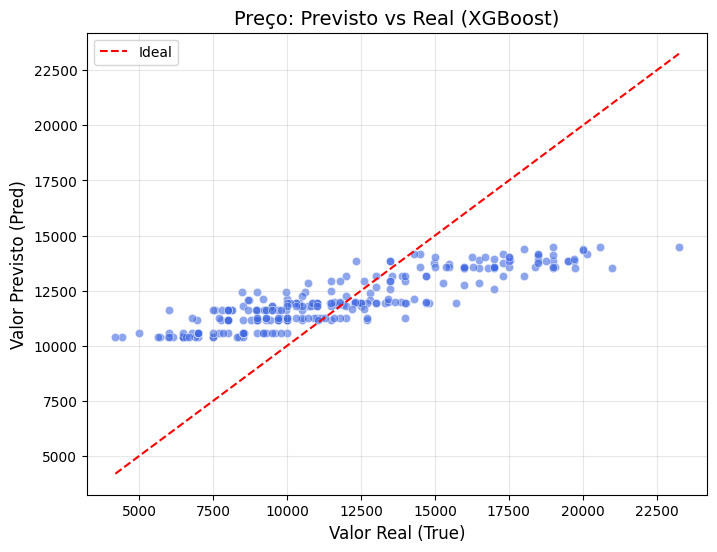

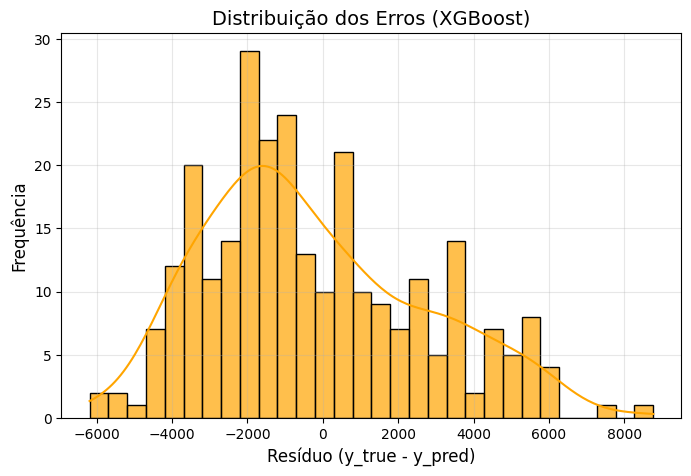

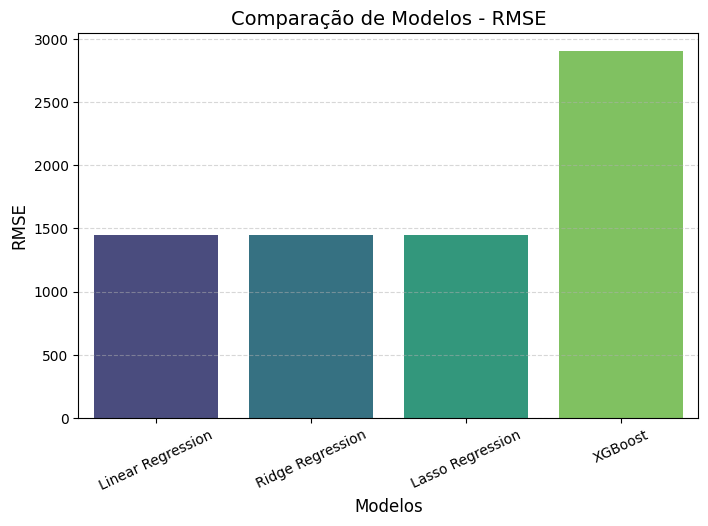

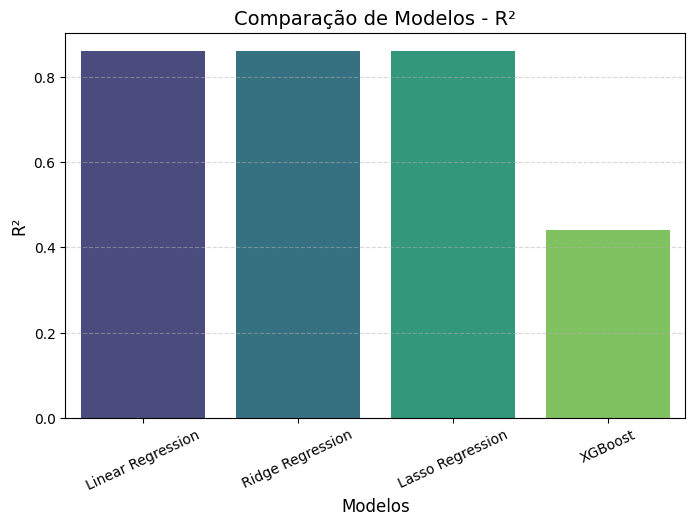

In [77]:
def plot_prediction_vs_actual(y_true, y_pred, title="Predição vs Valor Real"):
    plt.figure(figsize=(8, 6))
    
    sns.scatterplot(x=y_true, y=y_pred, color='royalblue', alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
             color='red', linestyle='--', label='Ideal') 
    
    plt.title(title, fontsize=14)
    plt.xlabel("Valor Real (True)", fontsize=12)
    plt.ylabel("Valor Previsto (Pred)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_residuals(y_true, y_pred, title="Resíduos (Erros)"):
    residuals = y_true - y_pred

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True, color='orange', alpha=0.7)
    plt.title(title, fontsize=14)
    plt.xlabel("Resíduo (y_true - y_pred)", fontsize=12)
    plt.ylabel("Frequência", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def compare_models(results_df, metric="RMSE"):
    if metric not in results_df.columns:
        raise ValueError(f"A coluna '{metric}' não existe em results_df.")

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Model', y=metric, data=results_df, palette='viridis')
    plt.title(f"Comparação de Modelos - {metric}", fontsize=14)
    plt.ylabel(metric, fontsize=12)
    plt.xlabel("Modelos", fontsize=12)
    plt.xticks(rotation=25)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

plot_prediction_vs_actual(y_val, pred_val, title="Preço: Previsto vs Real (XGBoost)")

plot_residuals(y_val, pred_val, title="Distribuição dos Erros (XGBoost)")

compare_models(results_df, metric="RMSE")

compare_models(results_df, metric="R²")